<a href="https://colab.research.google.com/github/NastaCom/NLP/blob/main/GorokhovaA_NLP_HW_16_var1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Интенты:

"Болталка" (FastText, датасет с урока №3 https://disk.yandex.ru/d/SLgpFrmrBubeYg).

"Книга рецептов" (предобученная модель huggingface sberbank-ai/rugpt3small_based_on_gpt2, finetuning на датасете https://www.kaggle.com/datasets/coolonce/recipes-and-interpretation-dim).

Базовые интенты - "текущее время", "прощание".
Для классификации интентов сначала проверяем наличие определенных слов ("время", "час", "спасибо", "пока"), далее классическая модель классификатора с TFIdf-векторайзером.

In [ ]:
!pip install python-telegram-bot==13.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.3/436.3 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 7.2 MB/s eta 0:00:00


## Подготовка данных

###Преобразование файла

In [ ]:
!pip install pymorphy2 stop_words annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.4/647.4 kB 30.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 57.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32897 sha256=fff0775ecc7c882940a40f5c2e538a2b9596149eaba211915f50a4d9e1cddc24
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
  Created wheel for annoy: filename=annoy-1.17.2-cp310-cp310-linux_x86_64.whl size=581416 sha256=854526e8ce3ed848fd53c5adba2341ac5b224755b2797ab864b70617e45446df
  Stored in directory: /root/.cache/pip/wheels/7a/d9/59/473fa56df8e39430eeda369500b4e7127f5b243ba24c3c4297


In [ ]:
import os
from telegram.ext  import Updater, CommandHandler, MessageHandler, filters
import string
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
import annoy
from gensim.models import Word2Vec, FastText
import pickle
import numpy as np
from tqdm import tqdm_notebook
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/Otvety.txt'

In [ ]:
assert True

#Small preprocess of the answers

question = None
written = False

with open("prepared_answers.txt", "w") as fout:
    with open(PATH, "r") as fin:
        for line in tqdm_notebook(fin):
            if line.startswith("---"):
                written = False
                continue
            if not written and question is not None:
                fout.write(question.replace("\t", " ").strip() + "\t" + line.replace("\t", " "))
                written = True
                question = None
                continue
            if not written:
                question = line.strip()
                continue

<ipython-input-6-c21458b67912>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(fin):


0it [00:00, ?it/s]

In [ ]:
morpher = MorphAnalyzer()
sw = set(get_stop_words("ru"))
exclude = set(string.punctuation)

In [ ]:
def preprocess_txt(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw and i != ""]
    return spls

In [ ]:
def preprocess_txt1(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i != ""]
    return spls

In [ ]:
assert True

# Preprocess for models fitting

sentences = []

morpher = MorphAnalyzer()
sw = set(get_stop_words("ru"))
exclude = set(string.punctuation)
c = 0

with open(PATH, "r") as fin:
    for line in tqdm_notebook(fin):
        spls = preprocess_txt(line)
        sentences.append(spls)
        c += 1
        if c > 500000:
            break

<ipython-input-10-57288e6b64a1>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(fin):


0it [00:00, ?it/s]

In [ ]:
import pickle

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/sent.pkl', 'wb') as f:
   pickle.dump(sentences, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/sent.pkl', 'rb') as f:
  sentences = pickle.load(f)

In [ ]:
print(len(sentences))
sentences[600]

500001


['посылать', 'посылать', 'посылать', 'далёкий']

In [ ]:
sentences = [i for i in sentences if len(i) > 2]
print('start train fasttext')
modelFT = FastText(sentences=sentences, vector_size=100, min_count=1, window=5, workers=8)
modelFT.save("ft_model")

start train fasttext


In [ ]:
modelFT.save("/content/drive/MyDrive/Colab Notebooks/ft_model")

###Обучение модели FastText

In [ ]:
modelFT = FastText.load("ft_model")

###Построение индекса "ближайших соседей" и словаря маппинга

In [ ]:
#modelFT = FastText.load("ft_model")
ft_index = annoy.AnnoyIndex(100 ,'angular')

index_map = {}
counter = 0

with open("prepared_answers.txt", "r") as f:
    for line in tqdm_notebook(f):
        n_ft = 0
        spls = line.split("\t")
        index_map[counter] = spls[1]
        question = preprocess_txt(spls[0])
        vector_ft = np.zeros(100)
        for word in question:
            if word in modelFT.wv:
                vector_ft += modelFT.wv[word]
                n_ft += 1
        if n_ft > 0:
            vector_ft = vector_ft / n_ft
        ft_index.add_item(counter, vector_ft)
            
        counter += 1

ft_index.build(10)
ft_index.save('speaker.ann')

<ipython-input-18-8a15aa787f5c>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(f):


0it [00:00, ?it/s]

True

In [ ]:
ft_index.save('/content/drive/MyDrive/Colab Notebooks/speaker.ann')

True

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/index_map.pkl', 'wb') as f:
   pickle.dump(index_map, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/index_map.pkl', 'rb') as f:
  index_map = pickle.load(f)

In [ ]:
modelFT = FastText.load("ft_model")

In [ ]:
ft_index = annoy.AnnoyIndex(100, 'angular')
ft_index.load('speaker.ann') 

True

In [ ]:
ft_index.get_nns_by_vector(np.zeros(100), 2)

[29789, 53935]

In [ ]:
df_rec = pd.read_csv('/content/all_recepies_inter.csv', sep='\t')

In [ ]:
df_rec.head()

,Unnamed: 0,name,composition,cooking_type,Инструкции,dish_type,Дата,photo,source,composition_inter
0,0,рассольник классический с перловкой и солеными...,"[{'Перловка': 0.1, 'unit': 'стак. (200 мл)'}, ...","варка,жарка",Подготовить указанные ингредиенты для приготов...,первое,05.06.2015,photo_1000menu_1.jpg,https://1000.menu/cooking/33395-rassolnik-s-pe...,"[{'product_id': 4253, 'name_source': 'Перловая..."
1,1,Суп пюре из белокочаной капусты,"[{'Капуста белокочанная': 50.0, 'unit': 'гр'},...",варка,"Необходимые ингредиенты\r\nНарезаем лук, морко...",первое,27.06.2015,photo_1000menu_2.jpg,https://1000.menu/cooking/25399-sup-pure-iz-be...,"[{'product_id': 2286, 'name_source': 'Капуста ..."
2,2,Постные щи из квашеной капусты,"[{'Капуста квашеная': 116.7, 'unit': 'гр'}, {'...","варка,жарка,тушение","Честно признаюсь, у меня не было репы на момен...",первое,12.02.2013,photo_1000menu_3.jpg,https://1000.menu/cooking/5159-postnje-shchi,"[{'product_id': 0, 'name_source': 'Капуста ква..."
3,3,Тюря- простой суп быстро и вкусно,"[{'Квас': 0.2, 'unit': 'л'}, {'Лук репчатый': ...",сырое,"\r\nНачинаем мы приготовление тюри с того, что...",первое,02.03.2011,photo_1000menu_4.jpg,https://1000.menu/cooking/5085-turya,"[{'product_id': 0, 'name_source': 'Квас', 'uni..."
4,4,Фасолевый суп из красной фасоли,"[{'Вода': 0.3, 'unit': 'л'}, {'Картошка': 0.3,...",варка,Подготовить ингредиенты. Для приготовления суп...,первое,28.01.2013,photo_1000menu_5.jpg,https://1000.menu/cooking/38765-fasolevyi-sup-...,"[{'product_id': 828, 'name_source': 'Вода', 'u..."


In [ ]:
df_rec.shape

(27884, 10)

In [ ]:
data = df_rec.loc[:5000, 'Инструкции']

In [ ]:
import re
from sklearn.model_selection import train_test_split

def build_text_files(data_json, dest_path):
    f = open(dest_path, 'w')
    data = ''
    for texts in data_json:
        summary = str(texts).strip()
        summary = re.sub(r"\s", " ", summary)
        data += summary + "  "
    f.write(data)

In [ ]:
train, test = train_test_split(data, test_size=0.15)

build_text_files(train,'train_dataset.txt')
build_text_files(test,'test_dataset.txt')

In [ ]:
print("Train dataset length: "+ str(len(train)))
print("Test dataset length: "+ str(len(test)))

Train dataset length: 4250
Test dataset length: 751


In [ ]:
!pip install transformers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.8 MB/s eta 0:00:00


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Токенайзер, пайплайн данных, модель

In [ ]:
from transformers import AutoTokenizer
#sberbank-ai/rugpt3large_based_on_gpt2
#sberbank-ai/rugpt3medium_based_on_gpt2
#sberbank-ai/rugpt3small_based_on_gpt2

tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
train_path = 'train_dataset.txt'
test_path = 'test_dataset.txt'

In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling

def load_dataset(train_path, test_path, tokenizer):
    train_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=train_path,
          block_size=128)

    test_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=test_path,
          block_size=128)

    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False,
    )
    return train_dataset, test_dataset, data_collator

train_dataset, test_dataset, data_collator = load_dataset(train_path, test_path, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [ ]:
from transformers import Trainer, TrainingArguments, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

###Fine-tuning модели

In [ ]:
training_args = TrainingArguments(
     "phrase",
    evaluation_strategy = "epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    learning_rate=1e-5,
    weight_decay=0.01,
    save_strategy='no',
    report_to='none',
    )

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.392400,2.266667
2,2.310400,2.244333


TrainOutput(global_step=3348, training_loss=2.3673333973582644, metrics={'train_runtime': 673.4172, 'train_samples_per_second': 19.887, 'train_steps_per_second': 4.972, 'total_flos': 874805723136000.0, 'train_loss': 2.3673333973582644, 'epoch': 2.0})

In [ ]:
trainer.save_model()

In [ ]:
tokenizer.save_pretrained('gpt_chf')
model.save_pretrained('model_gpt_chf')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt_chf")
model1 = AutoModelForCausalLM.from_pretrained("model_gpt_chf")

In [ ]:
prefix = "берем свежие томаты "

In [ ]:
prefix = "берем клубнику "

In [ ]:
tokens = tokenizer(prefix, return_tensors='pt')
#tokens = {k: v.to(model.device) for k, v in tokens.items()}

In [ ]:
#для теста оставляю длину +50

size = tokens['input_ids'].shape[1]
output = model1.generate( 
    **tokens, 
    #end_token=end_token_id,
    do_sample=False, 
    max_length=size+50, 
    repetition_penalty=5., 
    temperature=0.5,
    num_beams=2,
)

decoded = tokenizer.decode(output[0])
result = decoded[len(prefix):]
print(prefix + result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


берем клубнику  и нарежем ее кубиками. Посолим, поперчим и отправим в кастрюлю с кипящим бульоном. Варим до готовности картофеля.  2. В кастрюле разогреваем растительное масло (можно использовать оливковое) и


In [ ]:
def gpt_generate(prefix):
  tokens = tokenizer(prefix, return_tensors='pt')
  size = tokens['input_ids'].shape[1]
  output = model1.generate( 
      **tokens, 
      #end_token=end_token_id,
      do_sample=False, 
      max_length=size+50, 
      repetition_penalty=5., 
      temperature=0.5,
      num_beams=2,
  )

  decoded = tokenizer.decode(output[0])
  result = decoded[len(prefix):]
  return prefix + result

In [ ]:
gpt_generate(prefix)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'берем клубнику  и нарежем ее кубиками. Посолим, поперчим и отправим в кастрюлю с кипящим бульоном. Варим до готовности картофеля.  2. В кастрюле разогреваем растительное масло (можно использовать оливковое) и'

###Классификация интентов

In [ ]:
data_new = data.apply(lambda x: preprocess_txt(str(x)))

In [ ]:
data_new[:10]

0    [подготовить, указанный, ингредиент, приготовл...
1    [необходимый, ингредиент, нарезать, лук, морко...
2    [честно, признаться, репа, момент, приготовлен...
3    [начинать, приготовление, тюри, заранее, подго...
4    [подготовить, ингредиент, приготовление, суп, ...
5    [мясо, нарезать, порционный, кусочек, оставлят...
6    [брать, продукт, список, показать, фото, нагля...
7    [продукт, приготовление, турецкий, суп, булгур...
8    [приготовить, постный, гороховый, суп, подгото...
9    [подготовить, указанный, продукт, создание, су...
Name: Инструкции, dtype: object

In [ ]:
data_new.shape

(5001,)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = CountVectorizer(ngram_range=(1, 2))

In [ ]:
idxs = set(np.random.randint(0, len(index_map), len(data)))

In [ ]:
negative_texts = [" ".join(preprocess_txt(index_map[i])) for i in idxs]

In [ ]:
len(negative_texts)

4989

In [ ]:
positive_texts = [" ".join(val) for val in data_new.values]

In [ ]:
len(positive_texts)

5001

In [ ]:
negative_texts[13], positive_texts[13]

('вкус пеницилин',
 'приготовить ингредиент опёнок супчик хороший брать крупный оставить целый вкусно красиво набор овощ желание увеличить добавить макароны круп суп питательный сытный опёнок очищать земля мусор промывать проточный вода класть кастрюля заливать чистый вода добавлять соль варить 30 минута вода вариться опёнок сливать заливать свежеть вода приготовить овощ грибной супарепчатый лук чистить мелко реж морковь чистить натирать средний тёрка сковорода разогревать растительный масло класть подготовить репчатый лук морковь обжаривать овощ среднее огонь золотистость картофель чистить нарезать крупный кубик кастрюля опёнок класть овощной зажарка морковь репчатый лука добавлять порезать картофель ставить огонь доводить кипение убавлять огонь среднее добавлять соль вкус чёрный перец горошек варить 20 минутдобавлять лавровый лист сделать грибной суп ароматный варить 57 минута выключать огонь суп оставлять плита крышка потомиться 15 минута желание добавить суп мелко порезать зелень у

In [ ]:
dataset = negative_texts + positive_texts
labels = np.zeros(len(dataset))
labels[len(negative_texts):] = np.ones(len(positive_texts))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, stratify=labels,
                                                    random_state=13)

###Обучение модели классификатора

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.5 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier()
x_train_vec = vectorizer.fit_transform(X_train)
x_test_vec = vectorizer.transform(X_test)

cat_new = cat.fit(x_train_vec, y_train)

Learning rate set to 0.025025
0:	learn: 0.6436662	total: 1.15s	remaining: 19m 4s
1:	learn: 0.5988075	total: 2.84s	remaining: 23m 36s
2:	learn: 0.5592588	total: 4.54s	remaining: 25m 7s
3:	learn: 0.5212441	total: 6.34s	remaining: 26m 18s
4:	learn: 0.4873052	total: 7.46s	remaining: 24m 45s
5:	learn: 0.4548853	total: 8.5s	remaining: 23m 27s
6:	learn: 0.4274436	total: 9.53s	remaining: 22m 32s
7:	learn: 0.4013688	total: 10.5s	remaining: 21m 46s
8:	learn: 0.3777522	total: 11.5s	remaining: 21m 11s
9:	learn: 0.3555251	total: 12.6s	remaining: 20m 44s
10:	learn: 0.3328967	total: 13.6s	remaining: 20m 25s
11:	learn: 0.3153006	total: 14.7s	remaining: 20m 6s
12:	learn: 0.2989453	total: 15.7s	remaining: 19m 52s
13:	learn: 0.2837025	total: 16.8s	remaining: 19m 40s
14:	learn: 0.2697593	total: 18.4s	remaining: 20m 10s
15:	learn: 0.2555292	total: 20.2s	remaining: 20m 39s
16:	learn: 0.2428330	total: 21.8s	remaining: 21m 2s
17:	learn: 0.2315095	total: 23s	remaining: 20m 52s
18:	learn: 0.2200345	total: 24s	r

In [ ]:
input_txt = preprocess_txt('разогревать растительный масло класть подготовить репчатый лук морковь')
vect = vectorizer.transform([" ".join(input_txt)])
prediction = cat_new.predict_proba(vect)
print(prediction)

[[0.23688948 0.76311052]]


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true=y_test, y_pred=cat_new.predict(x_test_vec))

0.990990990990991

In [ ]:
import pickle
with open('cat_new.pkl', 'wb') as f:
   pickle.dump(cat_new, f)

In [ ]:
with open('cat_new.pkl', 'rb') as f:
  cat_new = pickle.load(f)

In [ ]:
def embed_txt(txt, idfs, midf):
    n_ft = 0
    vector_ft = np.zeros(100)
    for word in txt:
        if word in modelFT.wv:
            vector_ft += modelFT.wv[word] * 1 # idfs.get(word, midf)
            n_ft += 1 # idfs.get(word, midf)
    return vector_ft / n_ft

In [ ]:
import os
import logging
from telegram import Update
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters, CallbackContext

#Подключение чат-бота
###Добавление базовых интентов
###Проверка работы функции

In [ ]:
BOT_API = '5903651212:AAGqaqp7dN42arjsyElIrPYSkA8qpeSjA2g'
updater = Updater(BOT_API, use_context=True)  # Токен API к Telegram
dispatcher = updater.dispatcher
# updater = Updater(token='1058946299:AAFn0ESsBoqdzscvF-tYo0wcZvAUS_iJMCw') # Токен API к Telegram
# dispatcher = updater.dispatcher

In [ ]:
key_time = ['время','час']
#key_rec = ['рецепт', 'ингредиент', 'готовить']
key_ciao = ['спасибо']
def check_in_list(text, key_list):
    for w in text:
      if w in key_list:
        flag = True
        break
      else:
        flag = False
    return flag

In [ ]:
print(preprocess_txt1('сколько времени'))

['сколько', 'время']


In [ ]:
check_in_list(['сколько', 'время'], key_time)

True

In [ ]:
import datetime

In [ ]:
# тестирую финальную функцию
def process(text):
    input_txt = preprocess_txt(text)
    input_txt1 = preprocess_txt1(text)
    print(input_txt1) #без стоп-слов
    vect = vectorizer.transform([" ".join(input_txt)])
    prediction = cat_new.predict(vect)
    print(prediction)
    
    if check_in_list(input_txt1, key_time): 
      
        now = datetime.datetime.now()       
        print(now.strftime("%d-%m-%Y %H:%M"))
        return
    
    if check_in_list(input_txt1, key_ciao): 
            
        print('Рад был помочь!')
        return
    pred = cat_new.predict_proba(vect)
    print(pred)
    if prediction == 0:
        vect_ft = embed_txt(input_txt, {}, 1)
        ft_index_val, distances = ft_index.get_nns_by_vector(vect_ft, 1, include_distances=True)
        if distances[0] > 0.45:
          print(distances[0])
          print("Моя твоя не понимать")
          return
        print(index_map[ft_index_val[0]])
        return
    
    
    #if prediction[0] == 1:
        #gpt_generate(update.message.text)

    print(gpt_generate(text))

In [ ]:
process('разогревать растительный масло класть подготовить репчатый лук морковь')

['разогревать', 'растительный', 'масло', 'класть', 'подготовить', 'репчатый', 'лук', 'морковь']
[1.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[[0.23688948 0.76311052]]
разогревать растительный масло класть подготовить репчатый лук морковь и обжаривать до золотистого цвета.  2. Добавить в сковороду нарезанный кубиками картофель, жарить еще 5–7 минут на сильном огне с каждой стороны.  3. Влить бульон, довести до кипения, добавить


In [ ]:
process('который час')

['который', 'час']
[0.]
10-06-2023 13:45


In [ ]:
process('потерял ключи что делать')

['потерять', 'ключ', 'что', 'делать']
[0.]
[[0.99277212 0.00722788]]
Потеря ключей? Ничего страшного! У меня всегда забит в телефон телефонный номер взломщика замков. Парень работает чистенько. Плату берёт в зависимости от сложности замка. От 300-т до 700 рублей. Затем - прямиком в магазин за новым замком! Есть ещё один вариант - вызвать слесаря-сантехника из управляющей компании. Но это обойдётся значительно дороже: к цене нового замка добавится стоимость новой двери и её установки.. 



In [ ]:
process('спасибо')

['спасибо']
[0.]
Рад был помочь!


In [ ]:
def startCommand(update: Update, context: CallbackContext):
    update.message.reply_text('Чао! Я могу сказать, который час, придумать рецепт или просто поболтать')

def textMessage(update: Update, context: CallbackContext):
    input_txt = preprocess_txt(update.message.text)
    input_txt1 = preprocess_txt1(update.message.text) #без стоп-слов
    vect = vectorizer.transform([" ".join(input_txt)])
    prediction = cat_new.predict(vect)
    #print(prediction)
    
    if check_in_list(input_txt1, key_ciao): 
            
        update.message.reply_text('Рад был помочь!')
        return
    
    if check_in_list(input_txt1, key_time): 
      
        now = datetime.datetime.now()       
        update.message.reply_text(now.strftime("%d-%m-%Y %H:%M"))
        return

    #pred = lr_new.predict_proba(vect)
    #print(pred)
    if prediction == 0:
        vect_ft = embed_txt(input_txt, {}, 1)
        ft_index_val, distances = ft_index.get_nns_by_vector(vect_ft, 1, include_distances=True)
        if distances[0] > 0.45:
          print(distances[0])
          update.message.reply_text("Не понял, уточните вопрос")
          return
        update.message.reply_text(index_map[ft_index_val[0]])
        return
    
    
    #if prediction[0] == 1:
        #gpt_generate(update.message.text)

    update.message.reply_text(gpt_generate(update.message.text))

In [ ]:
# on different commands - answer in Telegram
dispatcher.add_handler(CommandHandler("start", startCommand))
dispatcher.add_handler(MessageHandler(Filters.text, textMessage))

# Start the Bot
updater.start_polling()
updater.idle()

# start_command_handler = CommandHandler('start', startCommand)
# text_message_handler = MessageHandler(Filters.text, textMessage)
# dispatcher.add_handler(start_command_handler)
# dispatcher.add_handler(text_message_handler)
# updater.start_polling(clean=True)
# updater.idle()

0.6750196814537048


###Итог работы моего бота

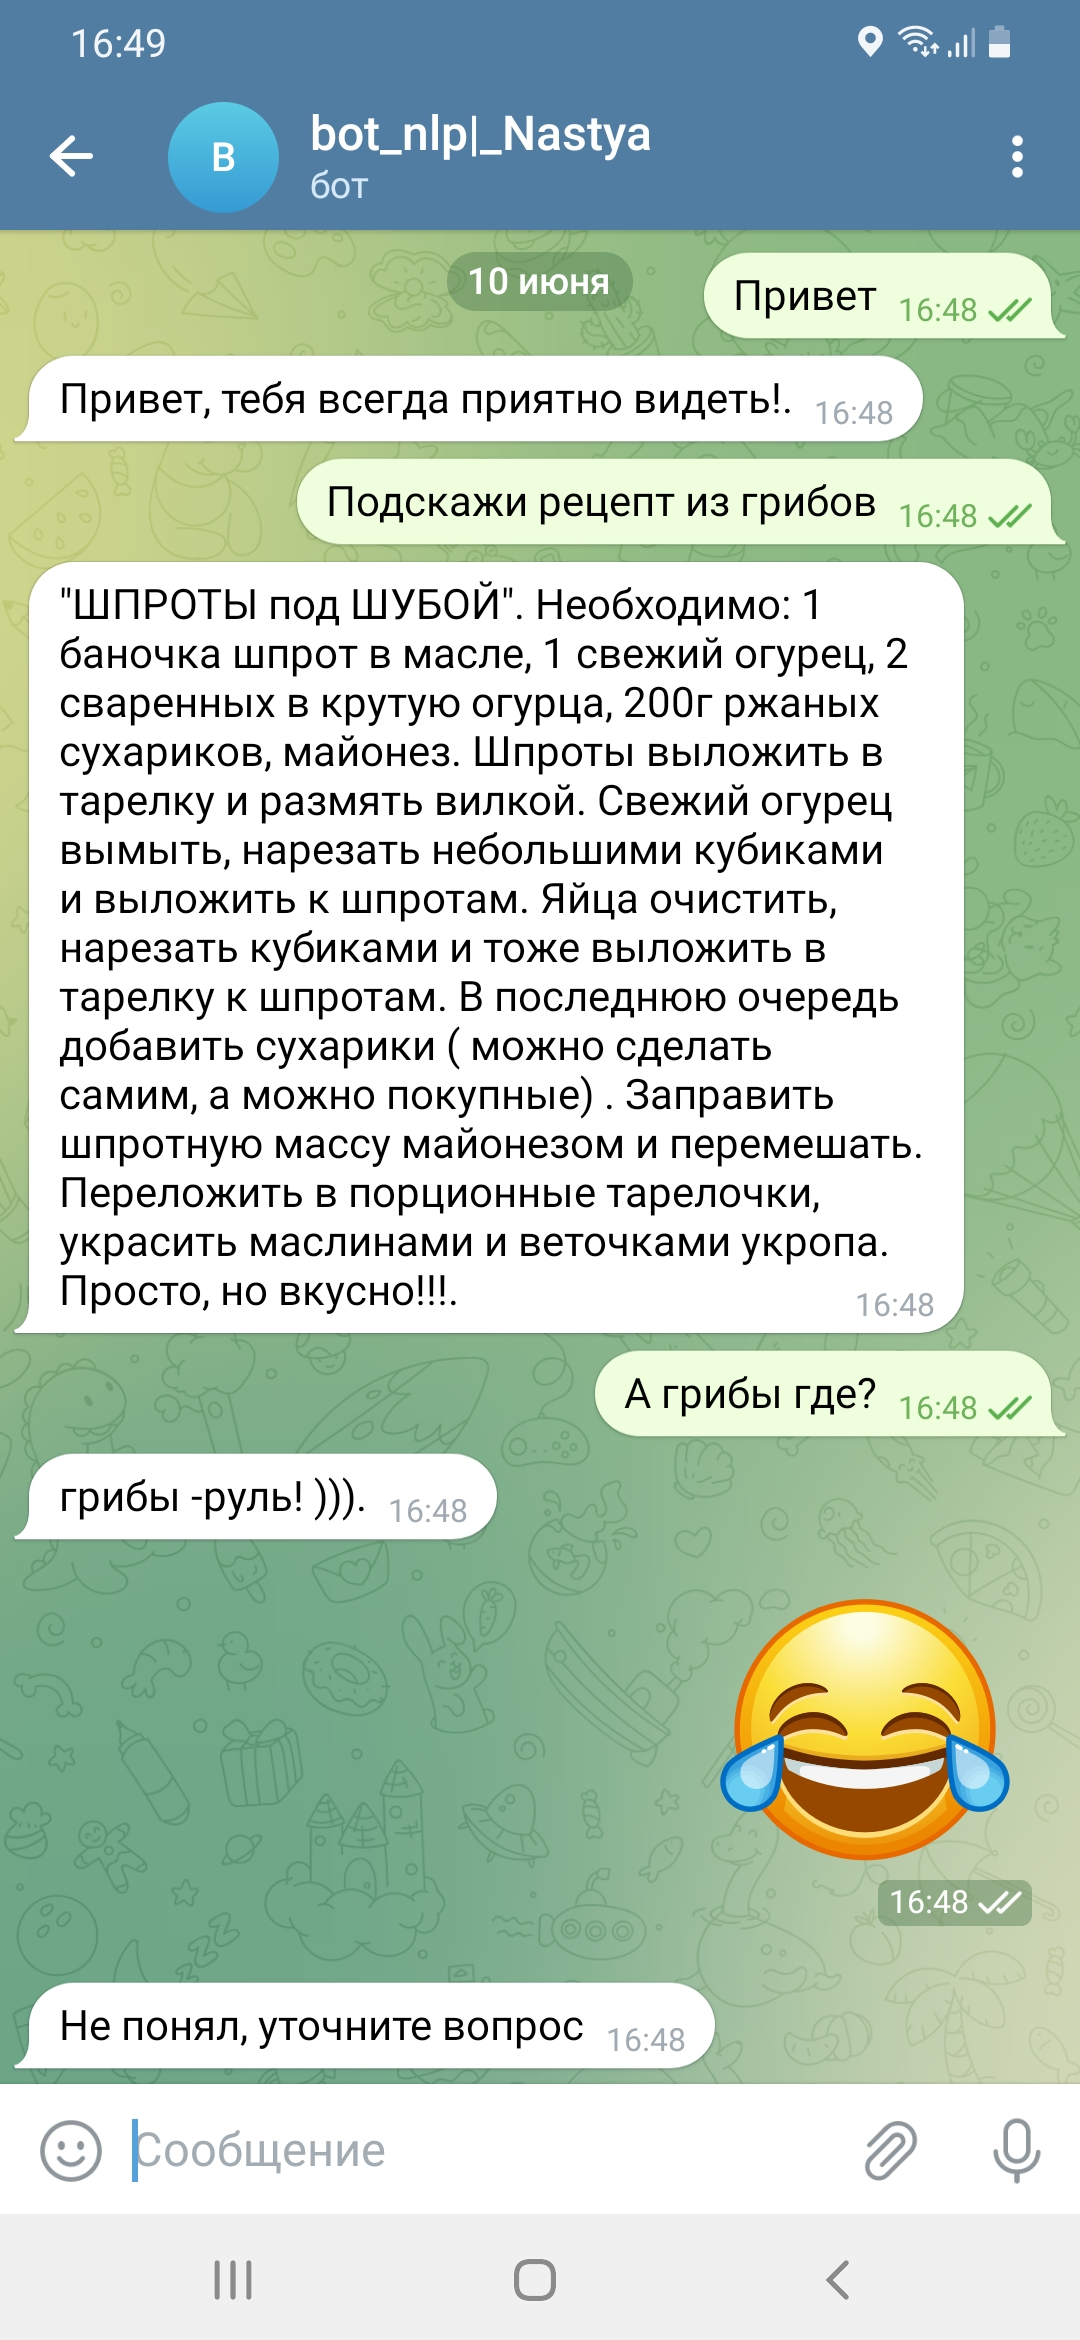

In [1]:
from IPython.display import Image
Image('bot_1.jpg')

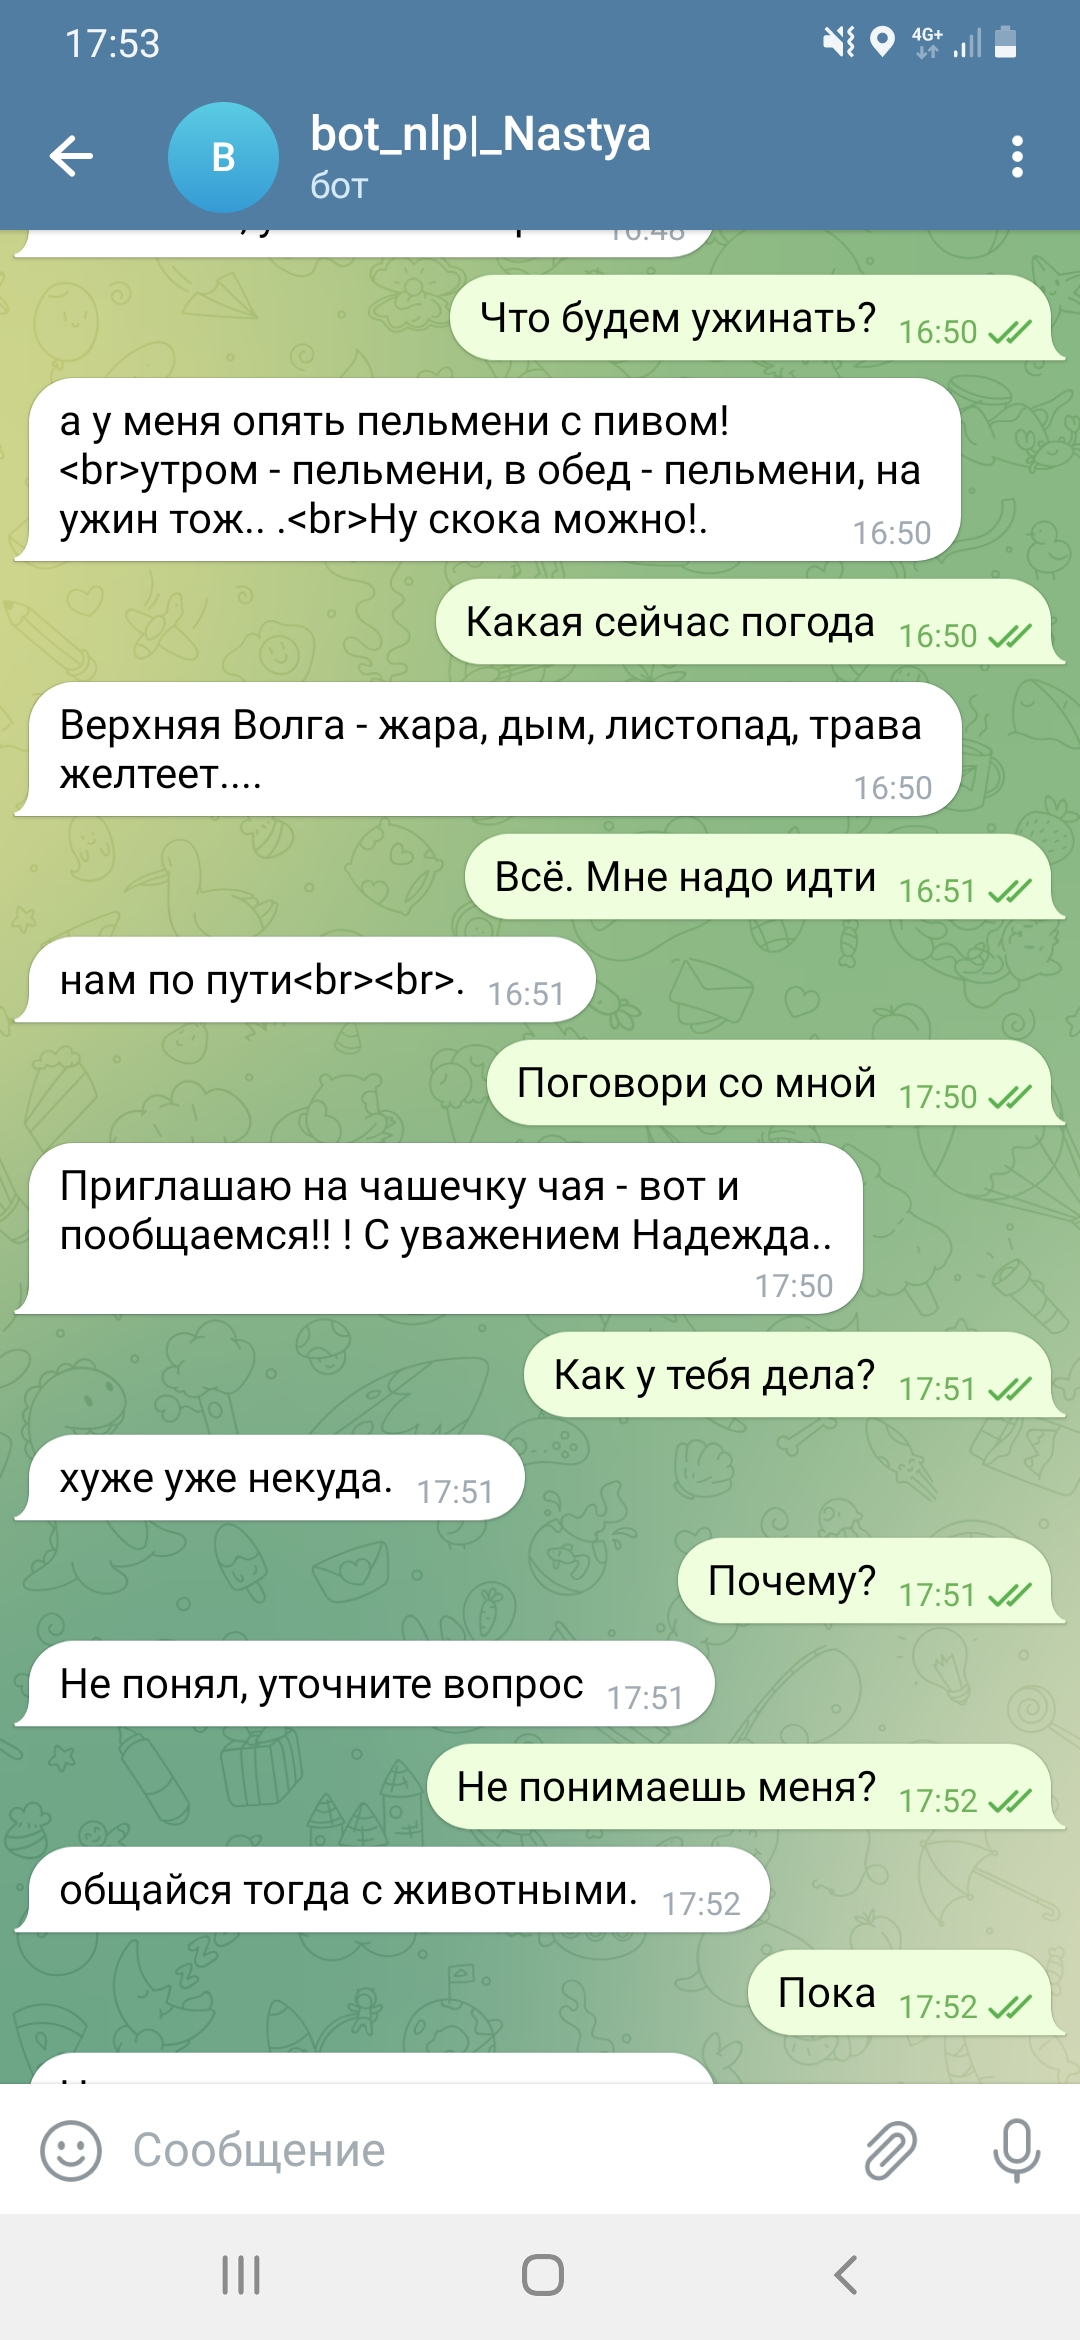

In [3]:
Image('bot_2.jpg')